In [1]:
!pip install qiskit[visualization] qiskit-aer rustworkx scipy matplotlib qiskit_algorithms --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00


# Node 20

## depth = 1

In [3]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

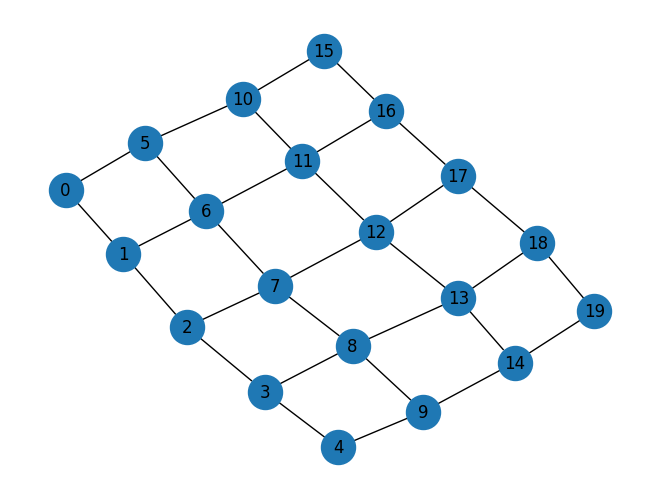

In [4]:
n = 20
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 5, 1.0),
    (1, 2, 1.0),
    (1, 6, 1.0),
    (2, 3, 1.0),
    (2, 7, 1.0),
    (3, 4, 1.0),
    (3, 8, 1.0),
    (4, 9, 1.0),
    (5, 6, 1.0),
    (5, 10, 1.0),
    (6, 7, 1.0),
    (6, 11, 1.0),
    (7, 8, 1.0),
    (7, 12, 1.0),
    (8, 9, 1.0),
    (8, 13, 1.0),
    (9, 14, 1.0),
    (10, 11, 1.0),
    (11, 12, 1.0),
    (12, 13, 1.0),
    (13, 14, 1.0),
    (10, 15, 1.0),
    (11, 16, 1.0),
    (12, 17, 1.0),
    (13, 18, 1.0),
    (14, 19, 1.0),
    (15, 16, 1.0),
    (16, 17, 1.0),
    (17, 18, 1.0),
    (18, 19, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [5]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIZIIIIZI', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIZIIIIZII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIZIIIIZIII', 'IIIIIIIIIIZIIIIZIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIZIIIIZIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIZIIIIZIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIZIIIIZIIIIIIII', 'IIIIIZIIIIZIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIZIIIIZIIIIIIIIII', 'IIIZIIIIZIIIIIIIIIII', 'IIZIIIIZIIIIIIIIIIII', 'IZIIIIZIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0

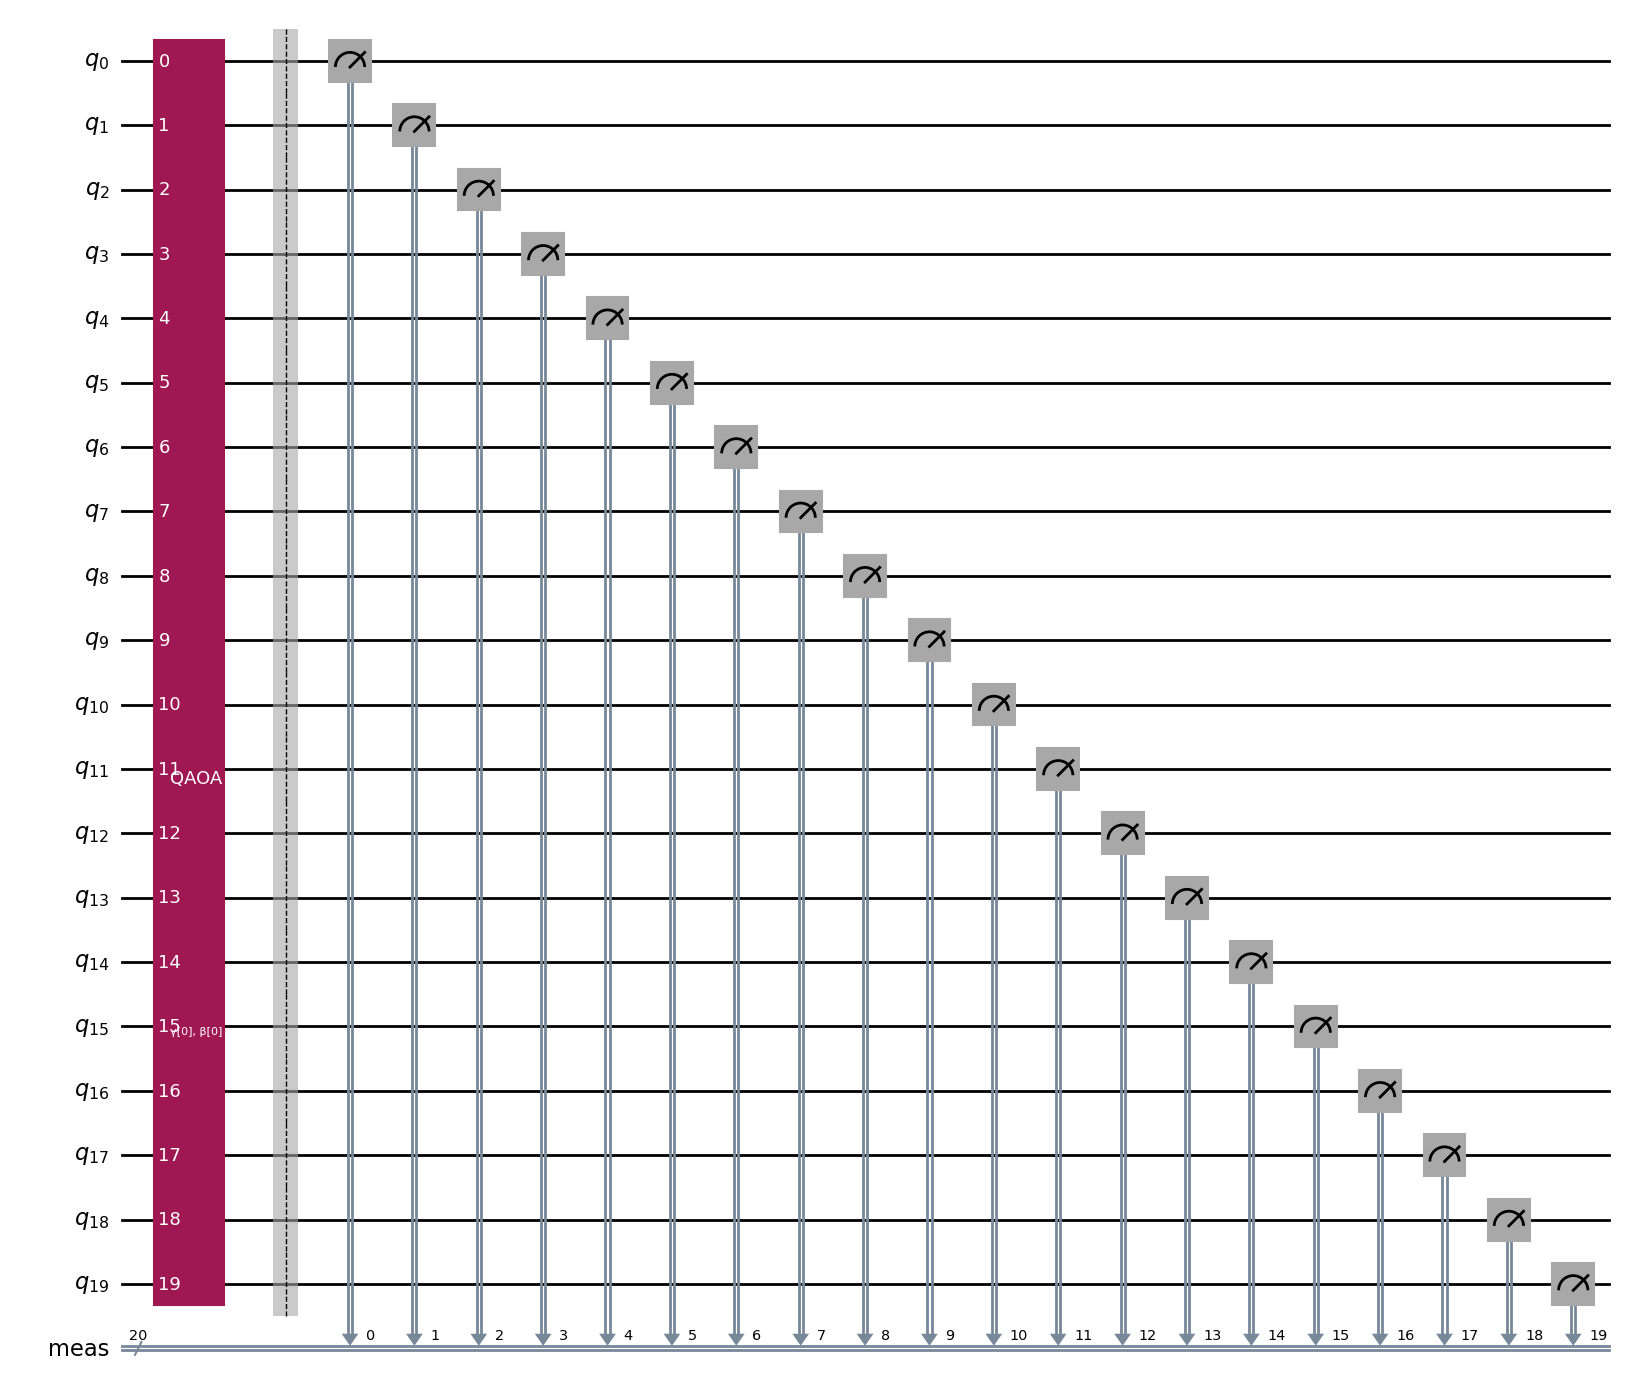

In [6]:
p = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

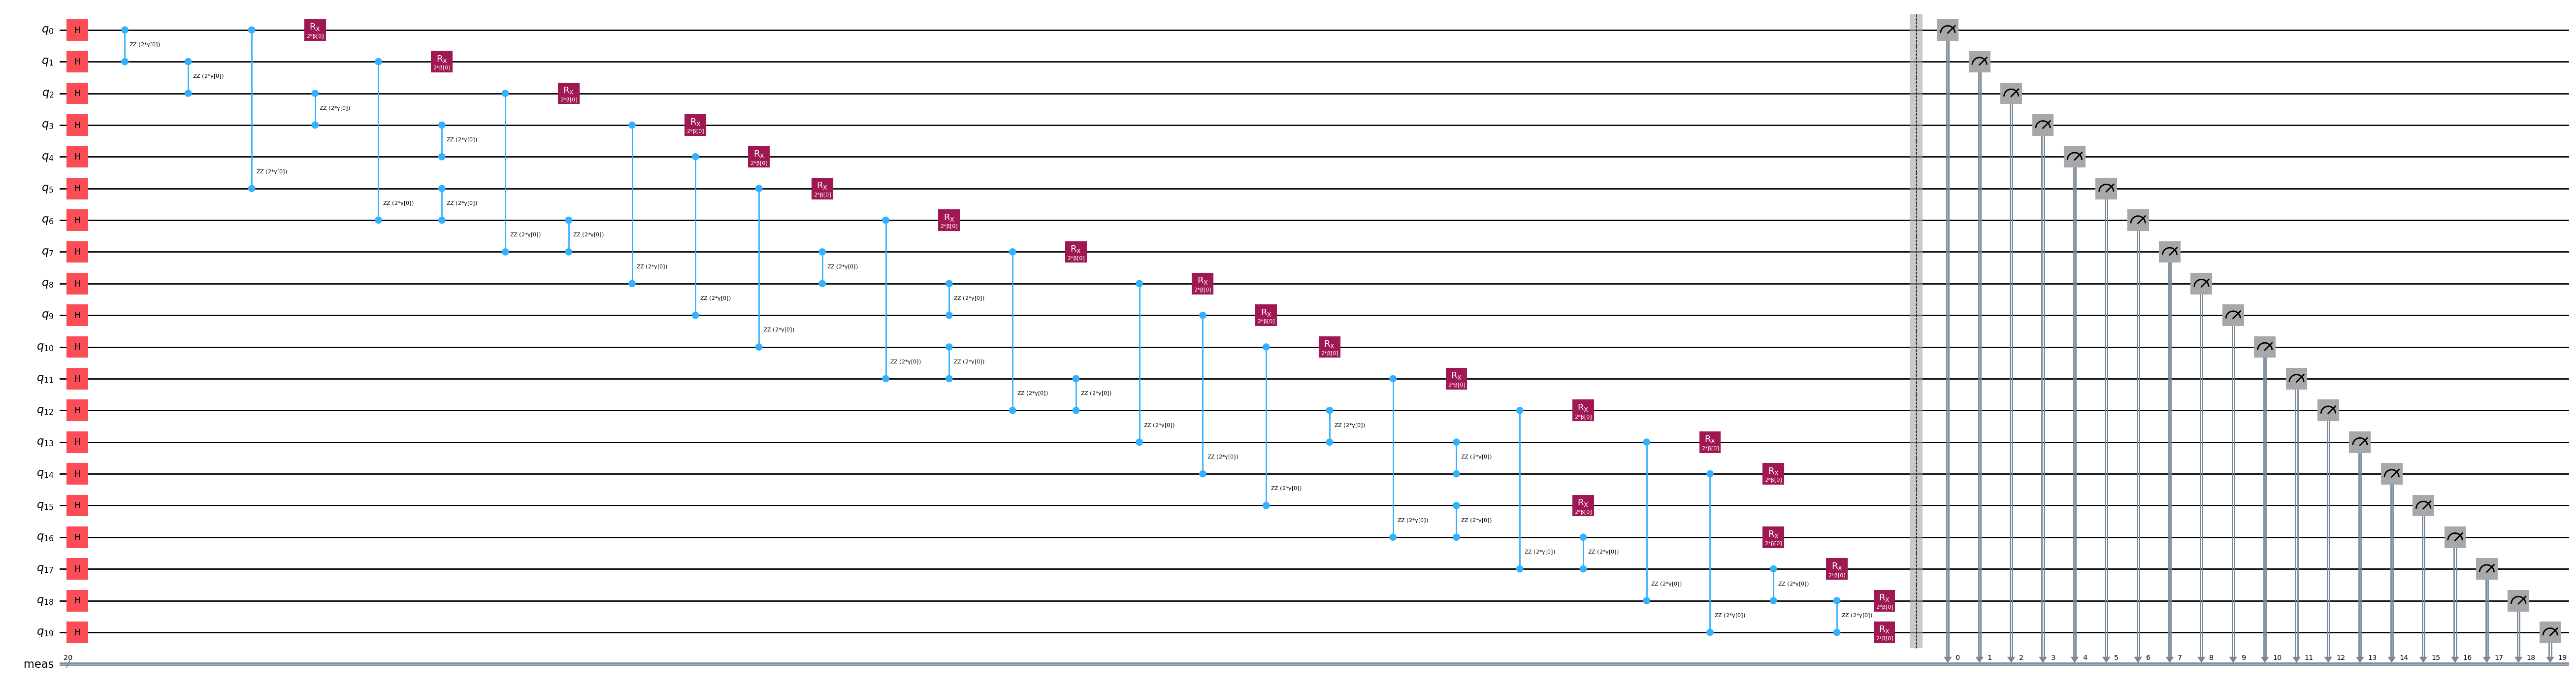

In [7]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [8]:
# Initial params
init_params = [np.pi / 2, np.pi / 2]

# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model, "shots": 1})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633], Cost: -0.130859375
[Noiseless] Params: [2.57079633 1.57079633], Cost: -0.130859375
[Noiseless] Params: [1.57079633 2.57079633], Cost: 0.216796875
[Noiseless] Params: [1.57079633 0.57079633], Cost: 0.044921875
[Noiseless] Params: [1.57079633 1.07079633], Cost: 0.056640625
[Noiseless] Params: [1.57079633 1.82079633], Cost: 0.19140625
[Noiseless] Params: [1.69579633 1.57079633], Cost: 0.08203125
[Noiseless] Params: [1.37145662 1.41991995], Cost: -0.095703125
[Noiseless] Params: [1.6540918  1.47759297], Cost: -0.06640625
[Noiseless] Params: [1.51677081 1.53937192], Cost: 0.2578125
[Noiseless] Params: [1.6139334 1.6160229], Cost: -0.271484375
[Noiseless] Params: [1.66521333 1.58029309], Cost: -0.001953125
[Noiseless] Params: [1.59171328 1.67443964], Cost: -0.138671875
[Noiseless] Params: [1.60282334 1.64523127], Cost: 0.048828125
[Noiseless] Params: [1.60291423 1.60494506], Cost: -0.23828125
[Noiseless] Params: [1.6

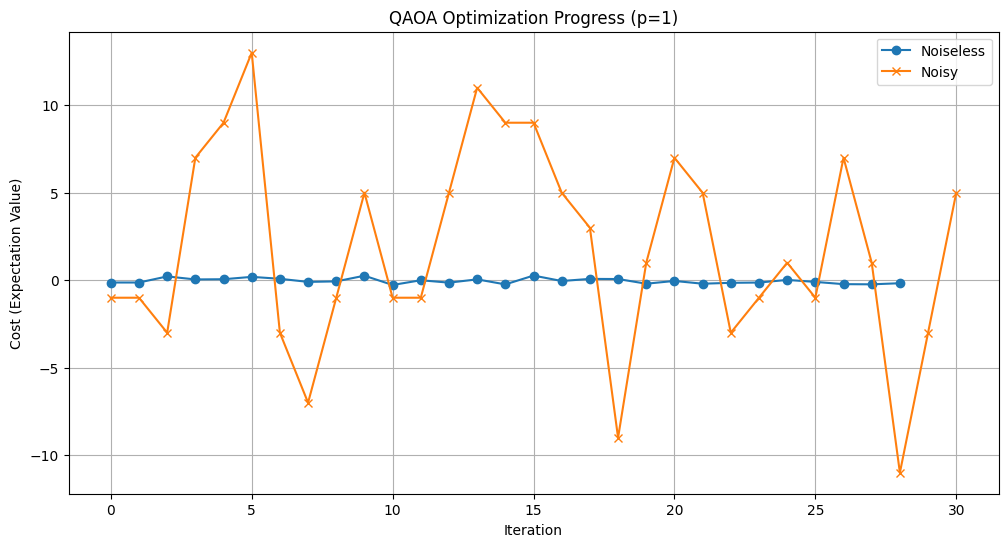

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', label="Noiseless")
plt.plot(objective_func_vals_noisy, marker='x', label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.legend()
plt.show()

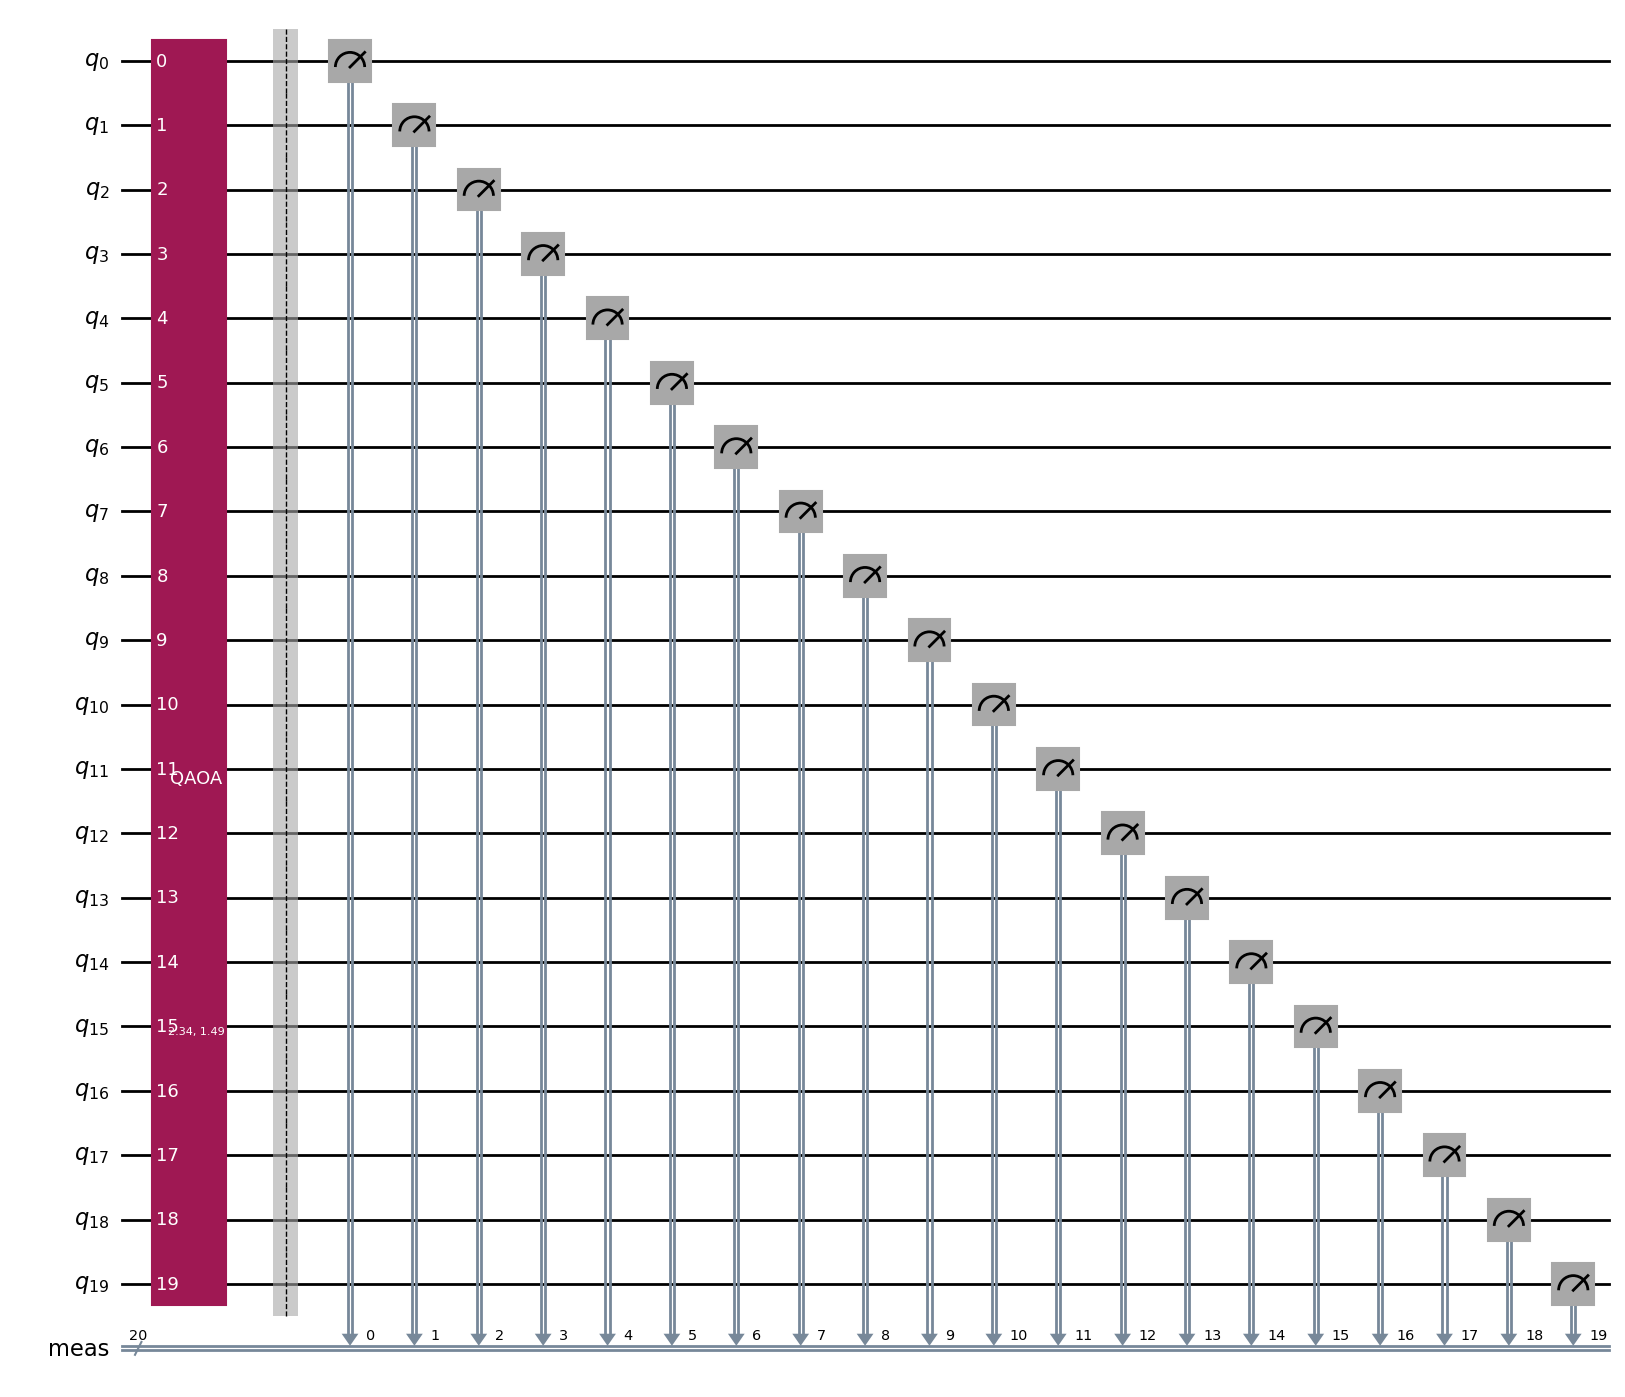

In [10]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

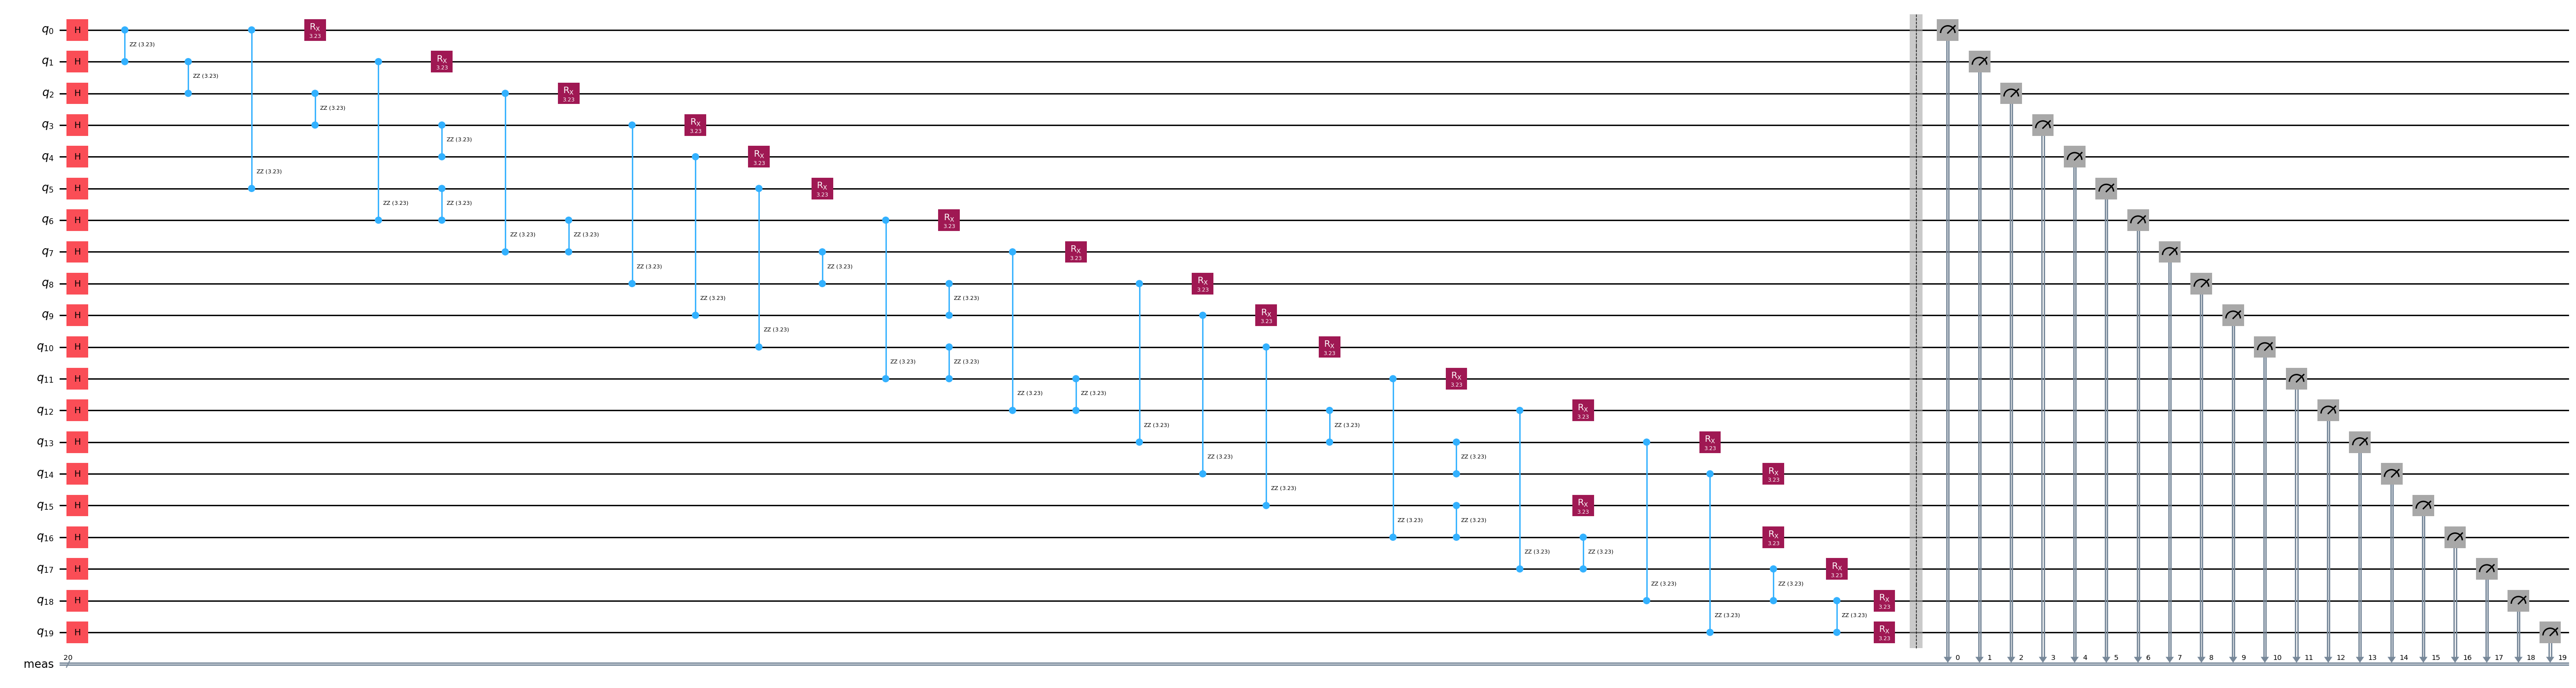

In [11]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [12]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=3)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=3)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [13]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

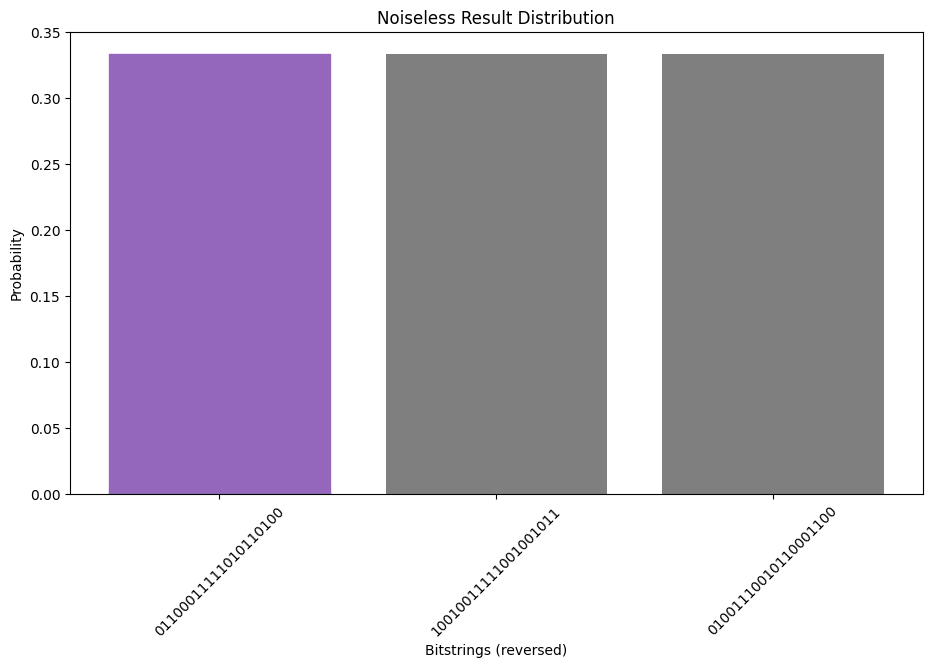

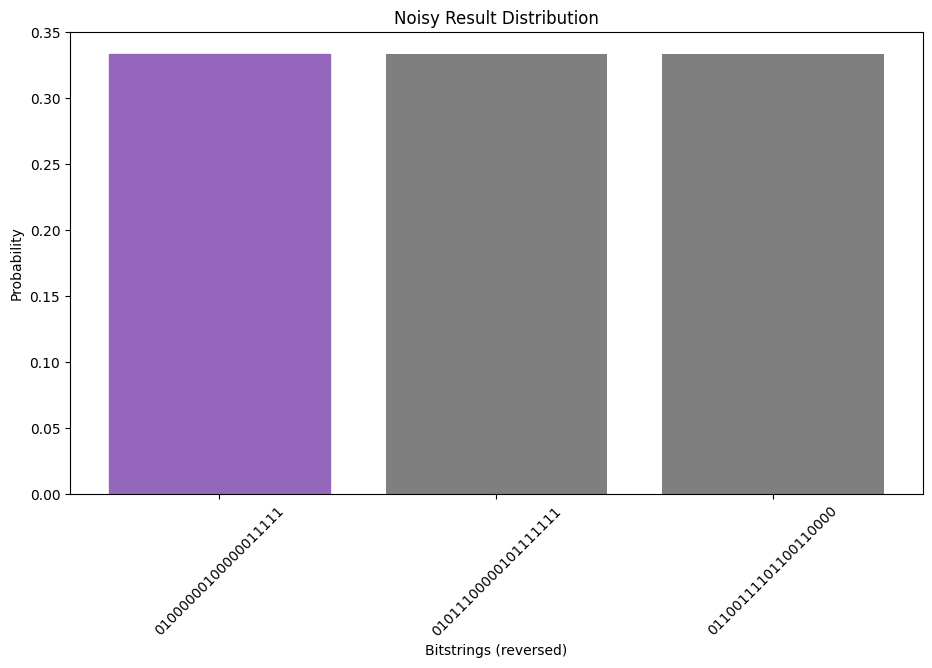

Noiseless bitstring: [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Noisy bitstring: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [14]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 16
Cut value (noisy): 12


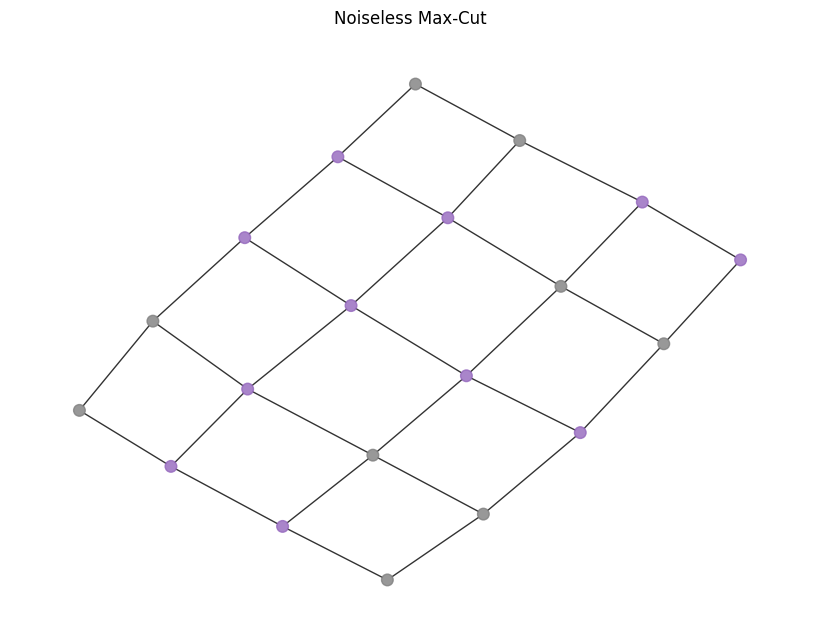

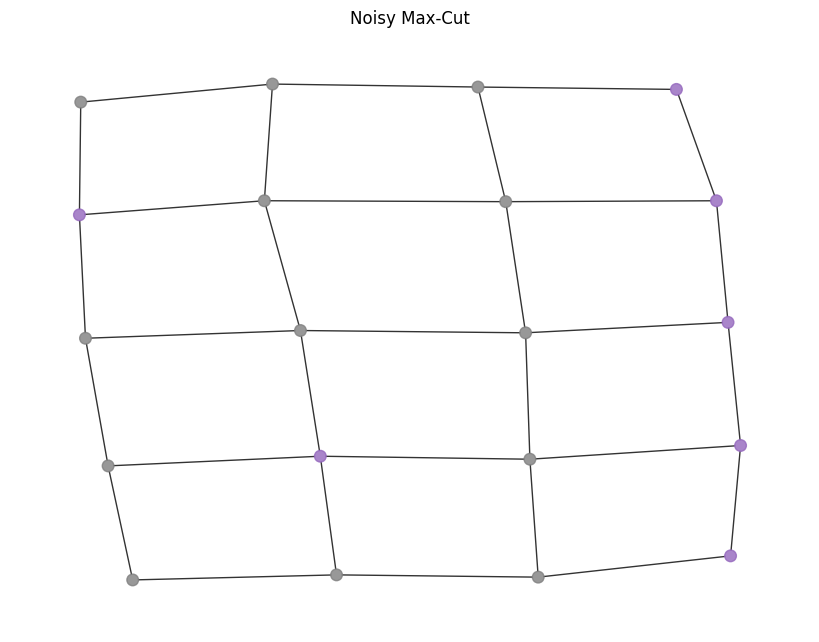

In [15]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring, "Noiseless Max-Cut")
plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

## depth = 2

In [16]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

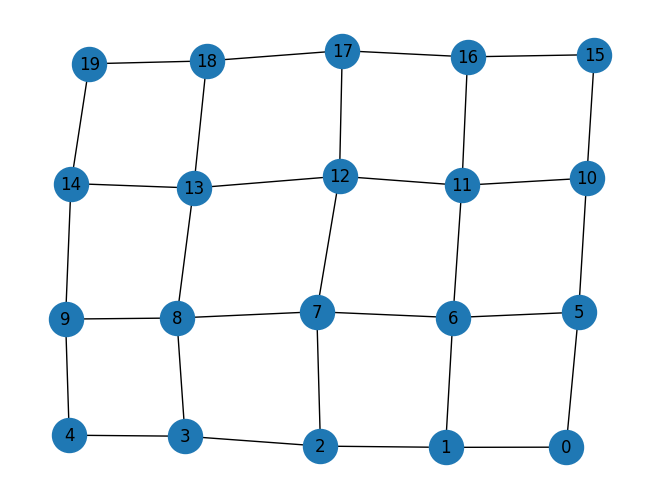

In [17]:
n = 20
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 5, 1.0),
    (1, 2, 1.0),
    (1, 6, 1.0),
    (2, 3, 1.0),
    (2, 7, 1.0),
    (3, 4, 1.0),
    (3, 8, 1.0),
    (4, 9, 1.0),
    (5, 6, 1.0),
    (5, 10, 1.0),
    (6, 7, 1.0),
    (6, 11, 1.0),
    (7, 8, 1.0),
    (7, 12, 1.0),
    (8, 9, 1.0),
    (8, 13, 1.0),
    (9, 14, 1.0),
    (10, 11, 1.0),
    (11, 12, 1.0),
    (12, 13, 1.0),
    (13, 14, 1.0),
    (10, 15, 1.0),
    (11, 16, 1.0),
    (12, 17, 1.0),
    (13, 18, 1.0),
    (14, 19, 1.0),
    (15, 16, 1.0),
    (16, 17, 1.0),
    (17, 18, 1.0),
    (18, 19, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [18]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIZIIIIZI', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIZIIIIZII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIZIIIIZIII', 'IIIIIIIIIIZIIIIZIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIZIIIIZIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIZIIIIZIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIZIIIIZIIIIIIII', 'IIIIIZIIIIZIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIZIIIIZIIIIIIIIII', 'IIIZIIIIZIIIIIIIIIII', 'IIZIIIIZIIIIIIIIIIII', 'IZIIIIZIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0

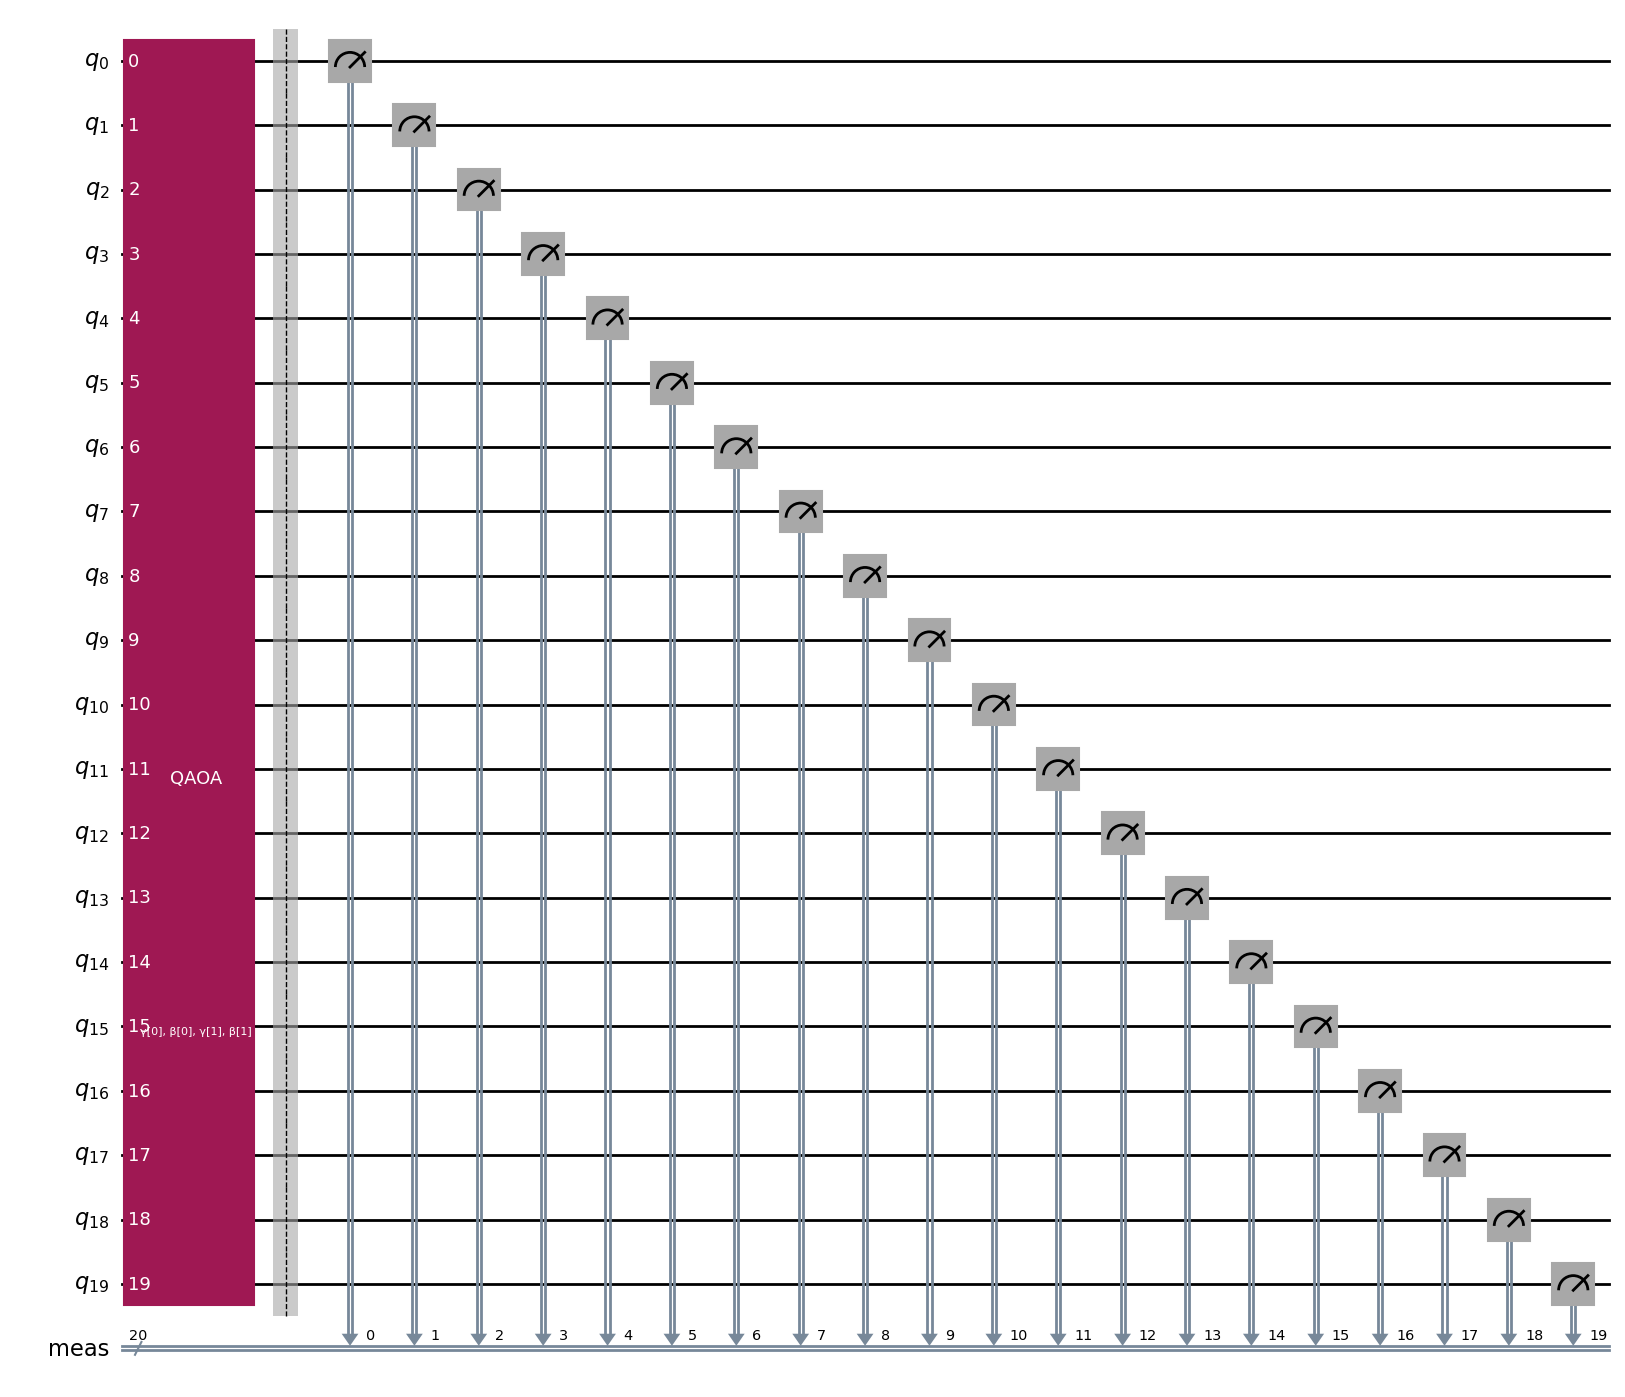

In [19]:
p = 2
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

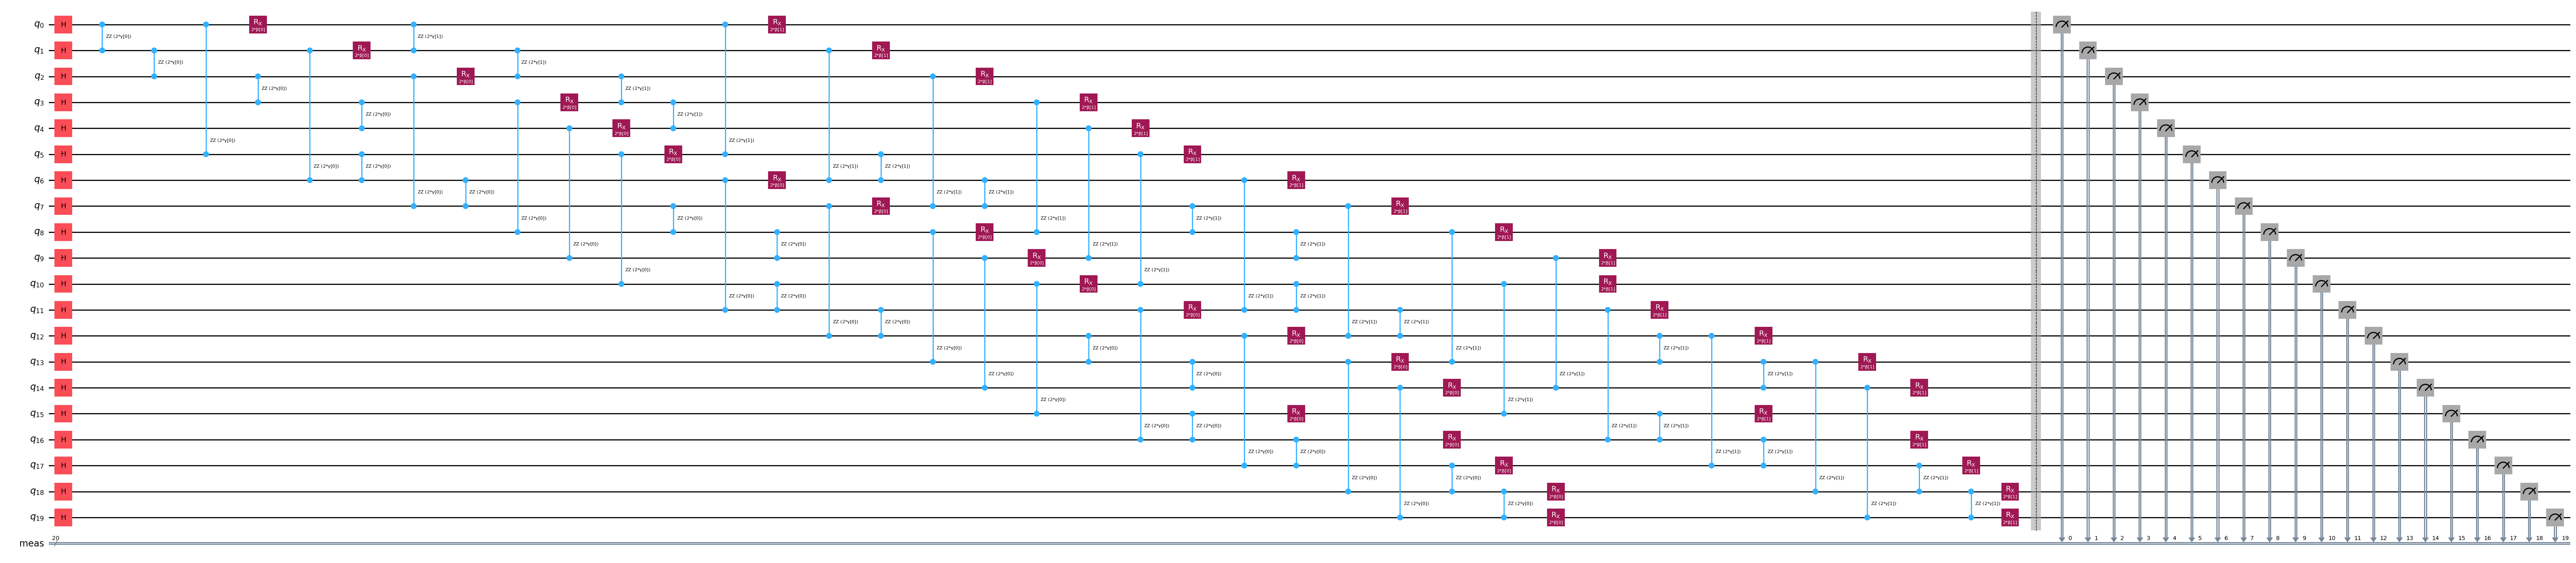

In [20]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [21]:
# Initial params
init_params = [np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2]

# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model, "shots": 1})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.005859375
[Noiseless] Params: [2.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.4609375
[Noiseless] Params: [1.57079633 2.57079633 1.57079633 1.57079633], Cost: -0.13671875
[Noiseless] Params: [1.57079633 2.57079633 2.57079633 1.57079633], Cost: -0.109375
[Noiseless] Params: [1.57079633 2.57079633 1.57079633 2.57079633], Cost: 0.041015625
[Noiseless] Params: [0.67790561 2.8505432  1.51714624 1.22207077], Cost: 9.83203125
[Noiseless] Params: [2.07069289 2.5771148  1.56958457 1.56291988], Cost: 0.232421875
[Noiseless] Params: [1.33192788 2.61662769 1.56200675 1.51366408], Cost: 3.37109375
[Noiseless] Params: [1.59435027 2.69355712 1.57079633 1.57079633], Cost: 0.087890625
[Noiseless] Params: [1.80861977 2.49378658 1.57032738 1.56774815], Cost: 0.373046875
[Noiseless] Params: [1.57056426 2.57084085 1.44579655 1.57079633], Cost: 5.189453125
[Noiseless] Params: [1.55616858 2.562892

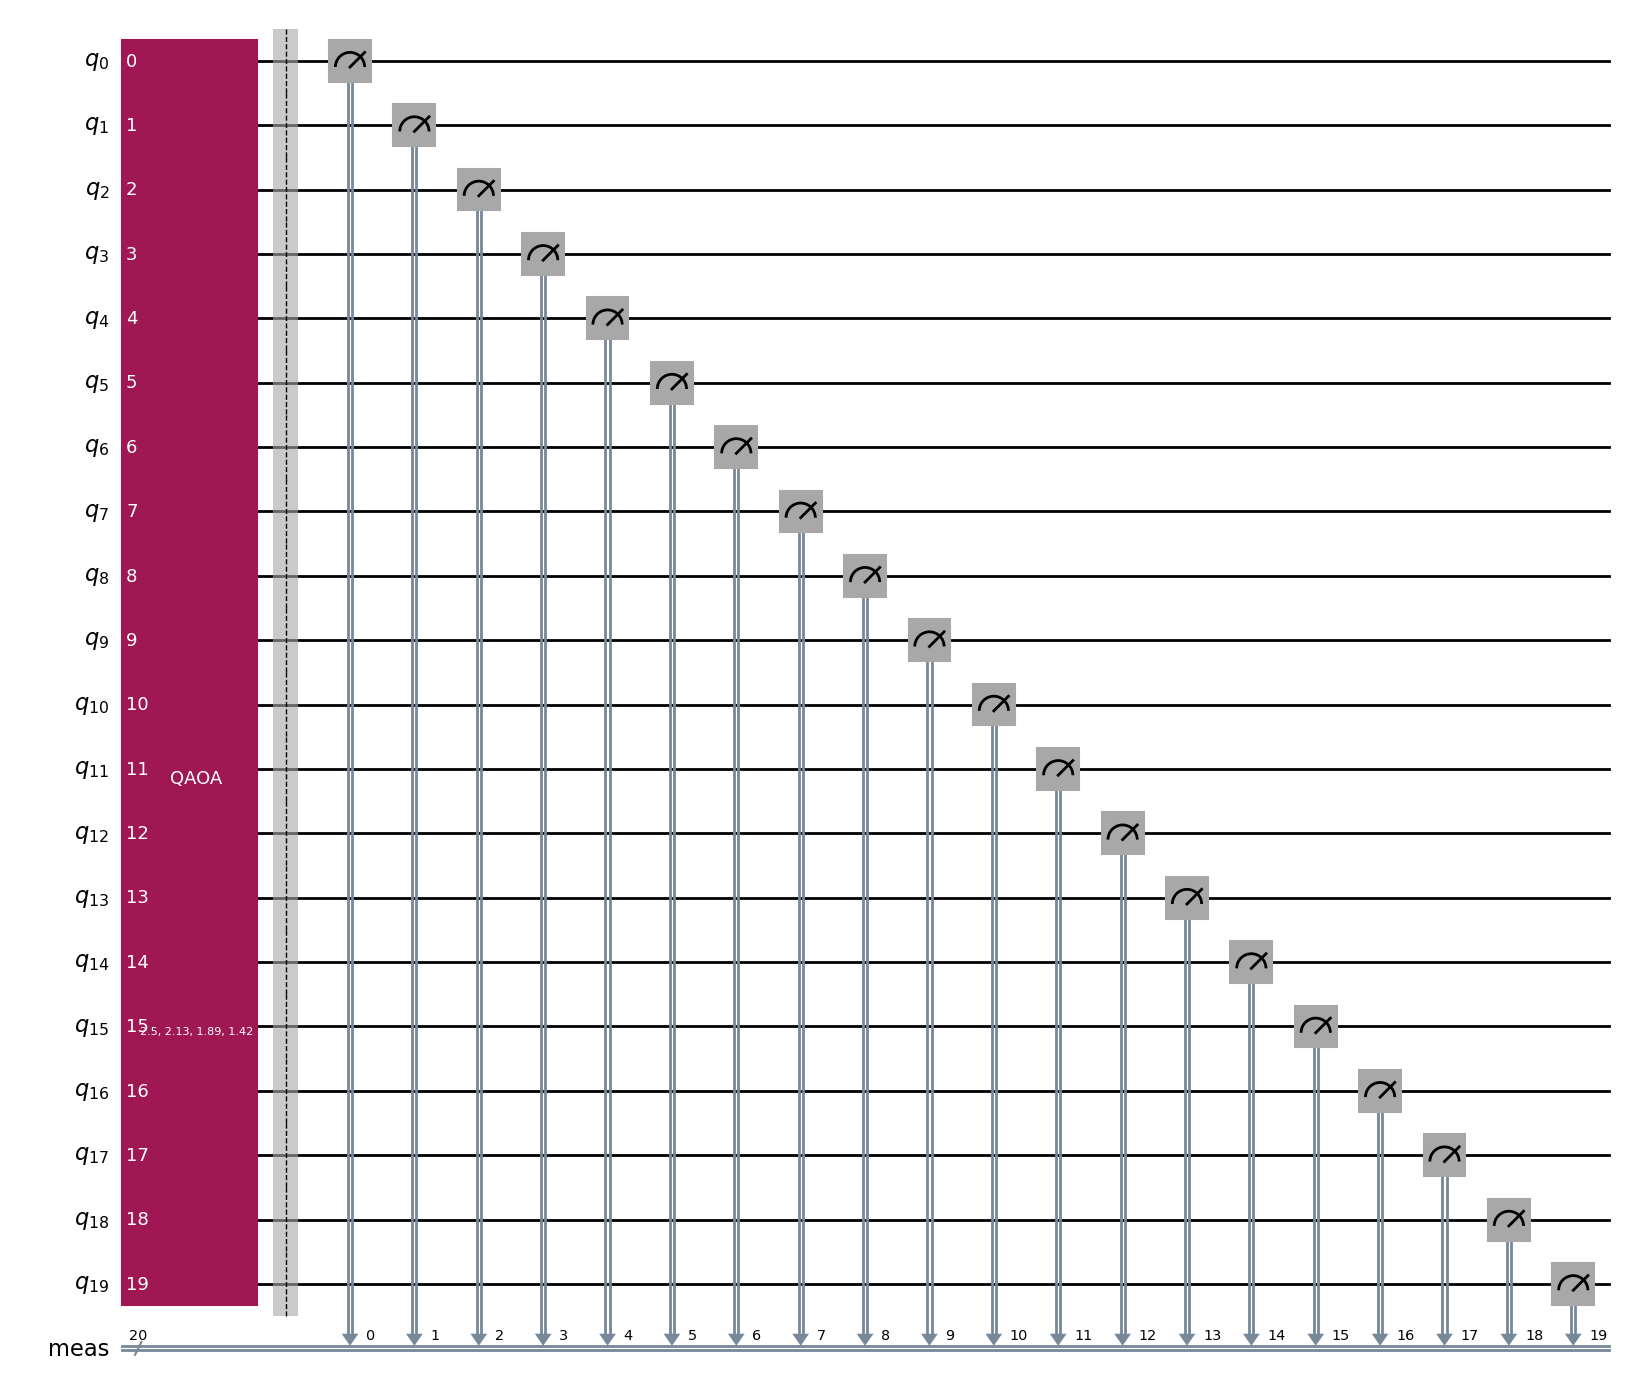

In [22]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

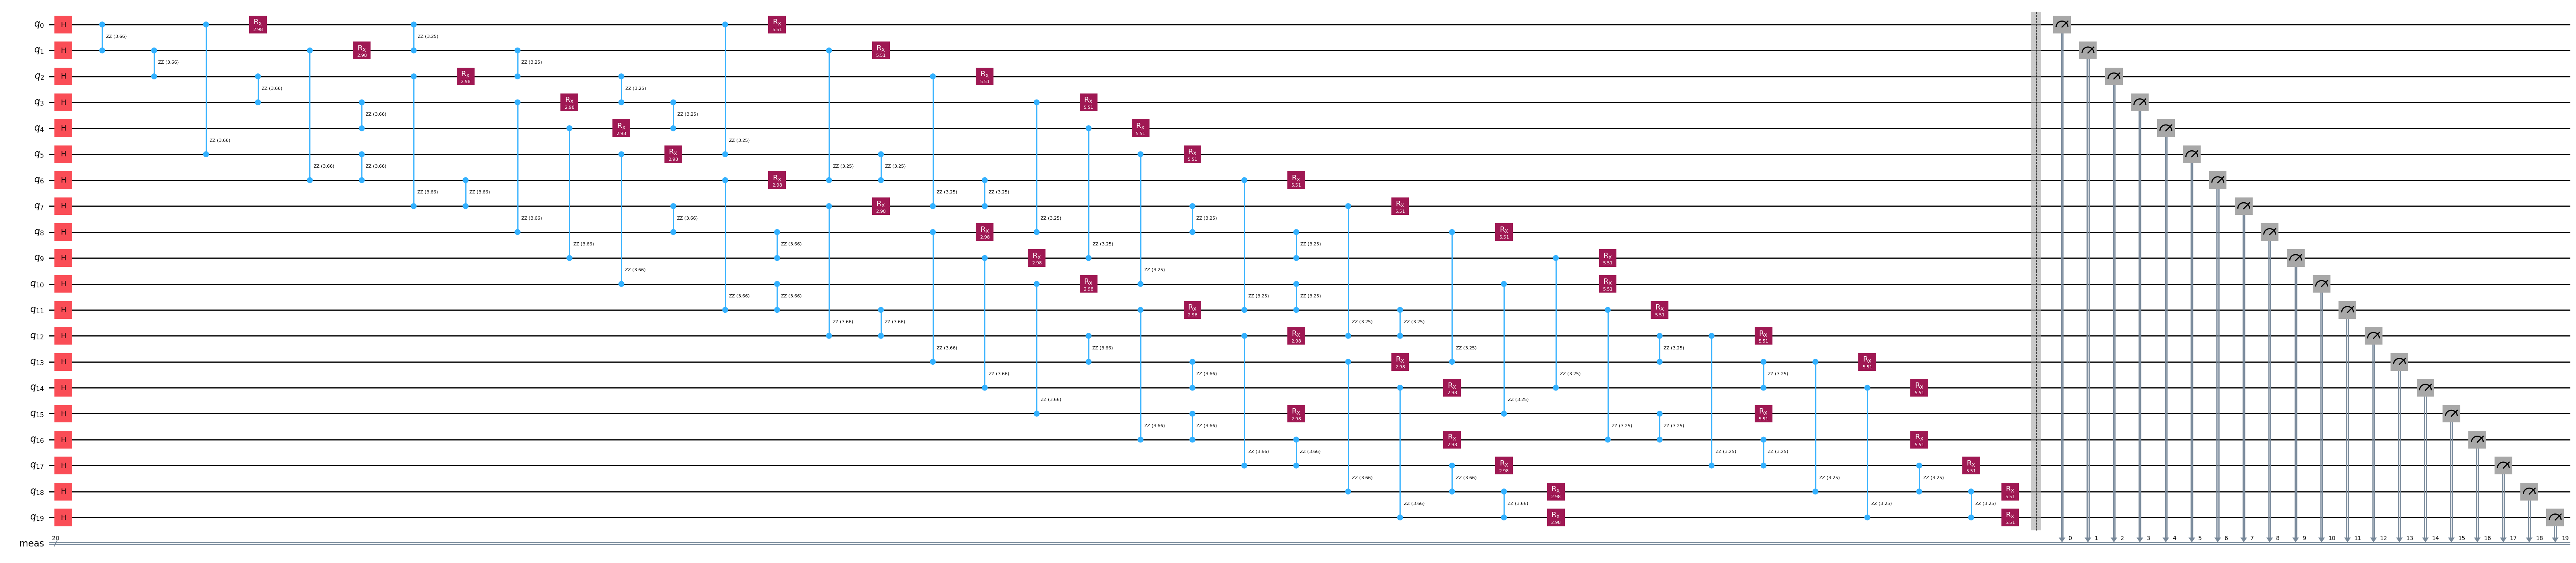

In [23]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [24]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=3)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=3)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [25]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

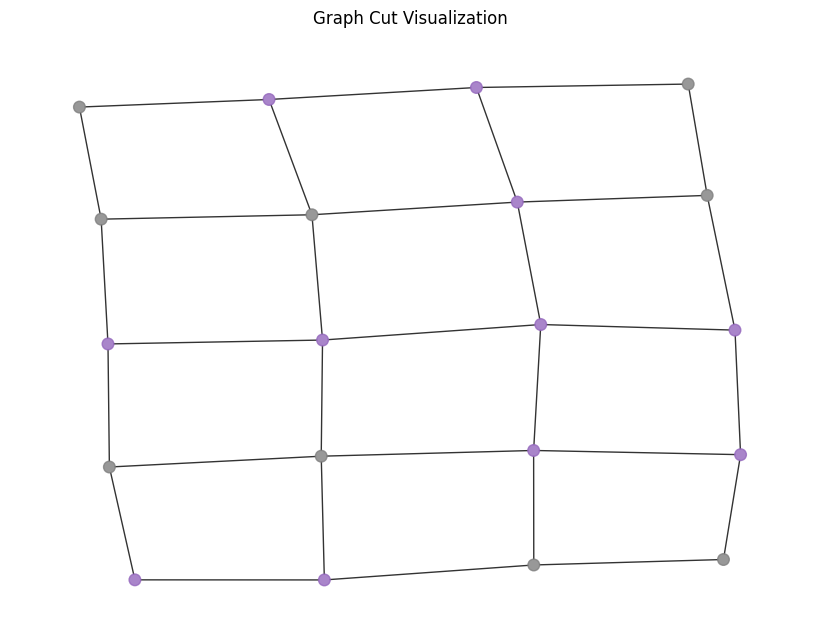

In [26]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

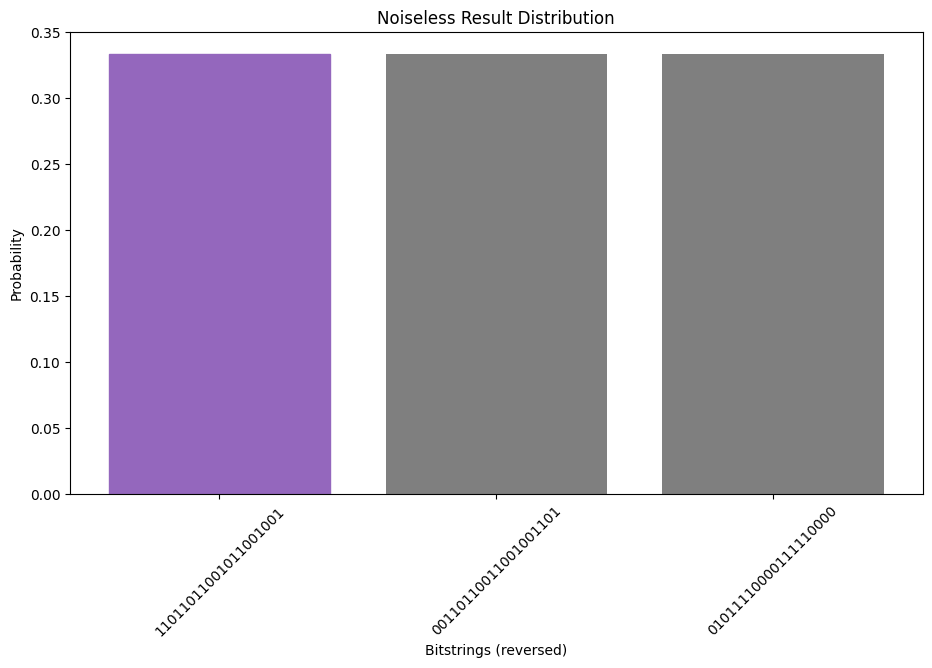

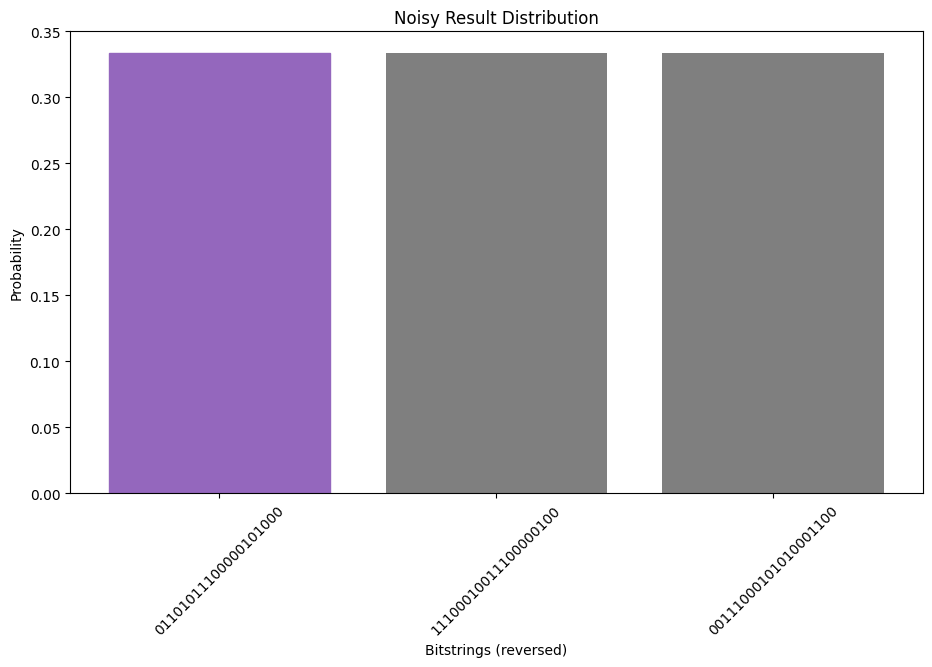

Noiseless bitstring: [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
Noisy bitstring: [0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]


In [27]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 22
Cut value (noisy): 16


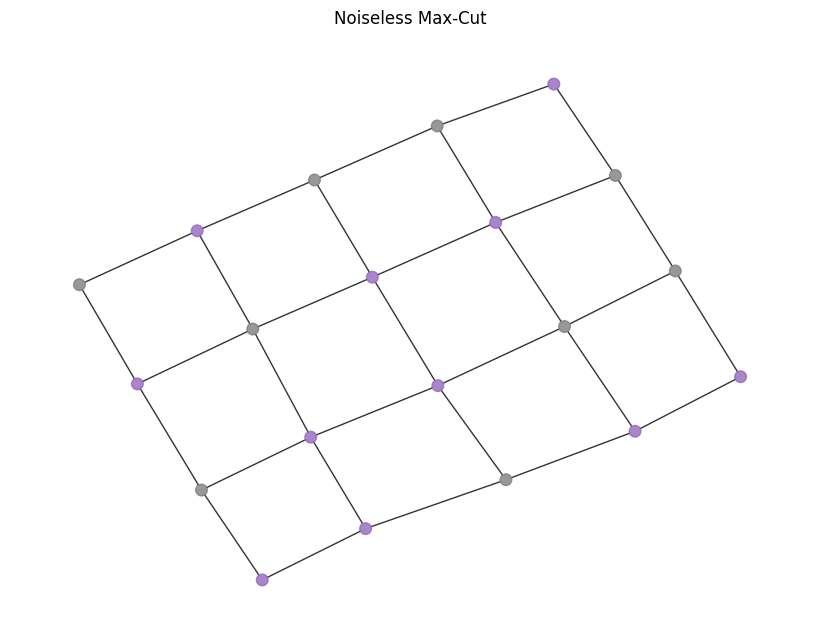

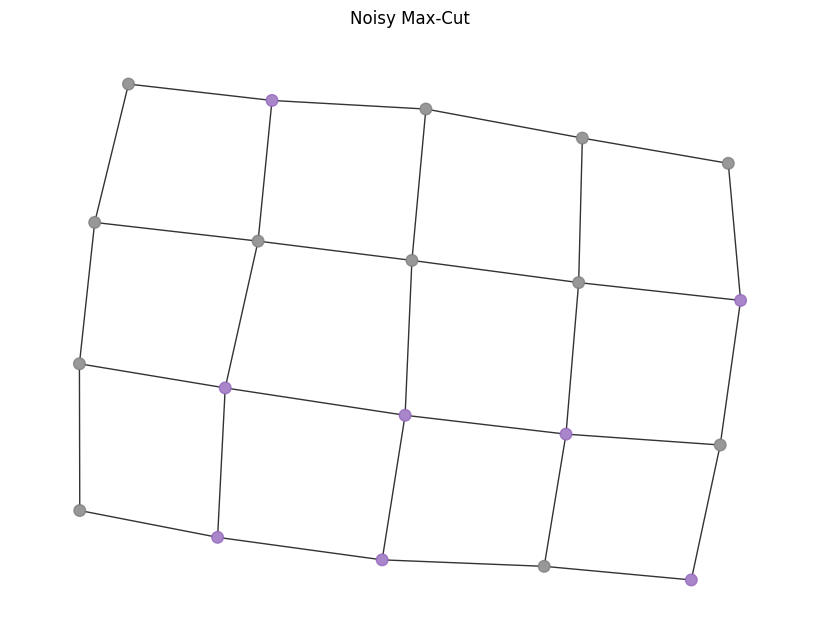

In [28]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring, "Noiseless Max-Cut")
plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

## depth = 3

In [29]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

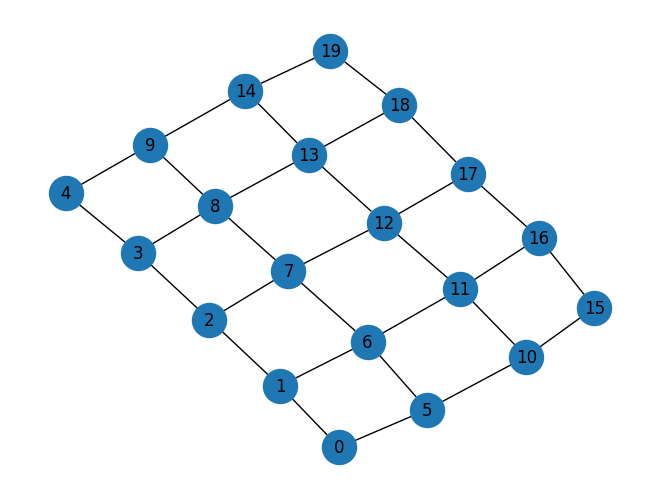

In [30]:
n = 20
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 5, 1.0),
    (1, 2, 1.0),
    (1, 6, 1.0),
    (2, 3, 1.0),
    (2, 7, 1.0),
    (3, 4, 1.0),
    (3, 8, 1.0),
    (4, 9, 1.0),
    (5, 6, 1.0),
    (5, 10, 1.0),
    (6, 7, 1.0),
    (6, 11, 1.0),
    (7, 8, 1.0),
    (7, 12, 1.0),
    (8, 9, 1.0),
    (8, 13, 1.0),
    (9, 14, 1.0),
    (10, 11, 1.0),
    (11, 12, 1.0),
    (12, 13, 1.0),
    (13, 14, 1.0),
    (10, 15, 1.0),
    (11, 16, 1.0),
    (12, 17, 1.0),
    (13, 18, 1.0),
    (14, 19, 1.0),
    (15, 16, 1.0),
    (16, 17, 1.0),
    (17, 18, 1.0),
    (18, 19, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [31]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIZIIIIZI', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIZIIIIZII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIZIIIIZIII', 'IIIIIIIIIIZIIIIZIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIZIIIIZIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIZIIIIZIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIZIIIIZIIIIIIII', 'IIIIIZIIIIZIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIZIIIIZIIIIIIIIII', 'IIIZIIIIZIIIIIIIIIII', 'IIZIIIIZIIIIIIIIIIII', 'IZIIIIZIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0

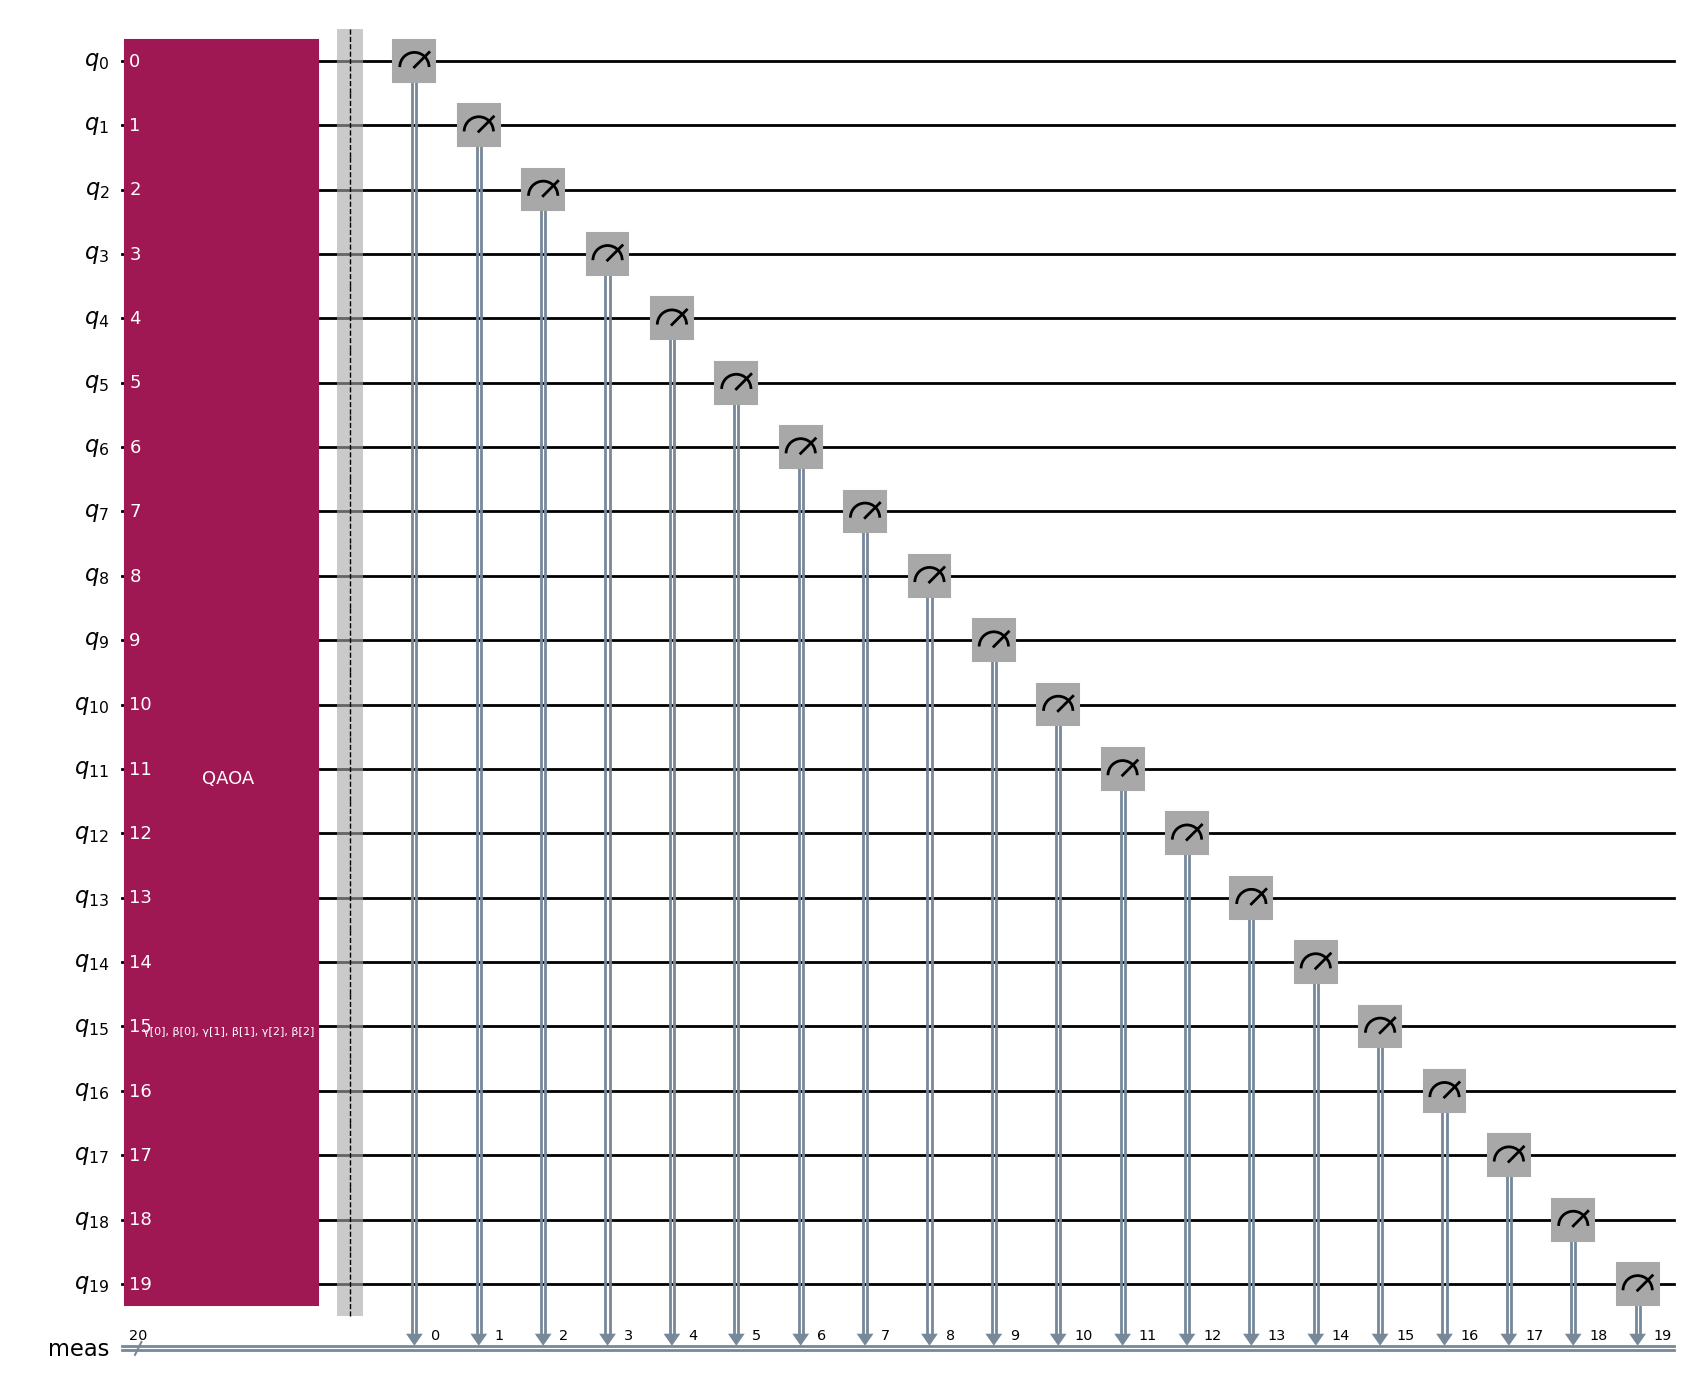

In [32]:
p = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

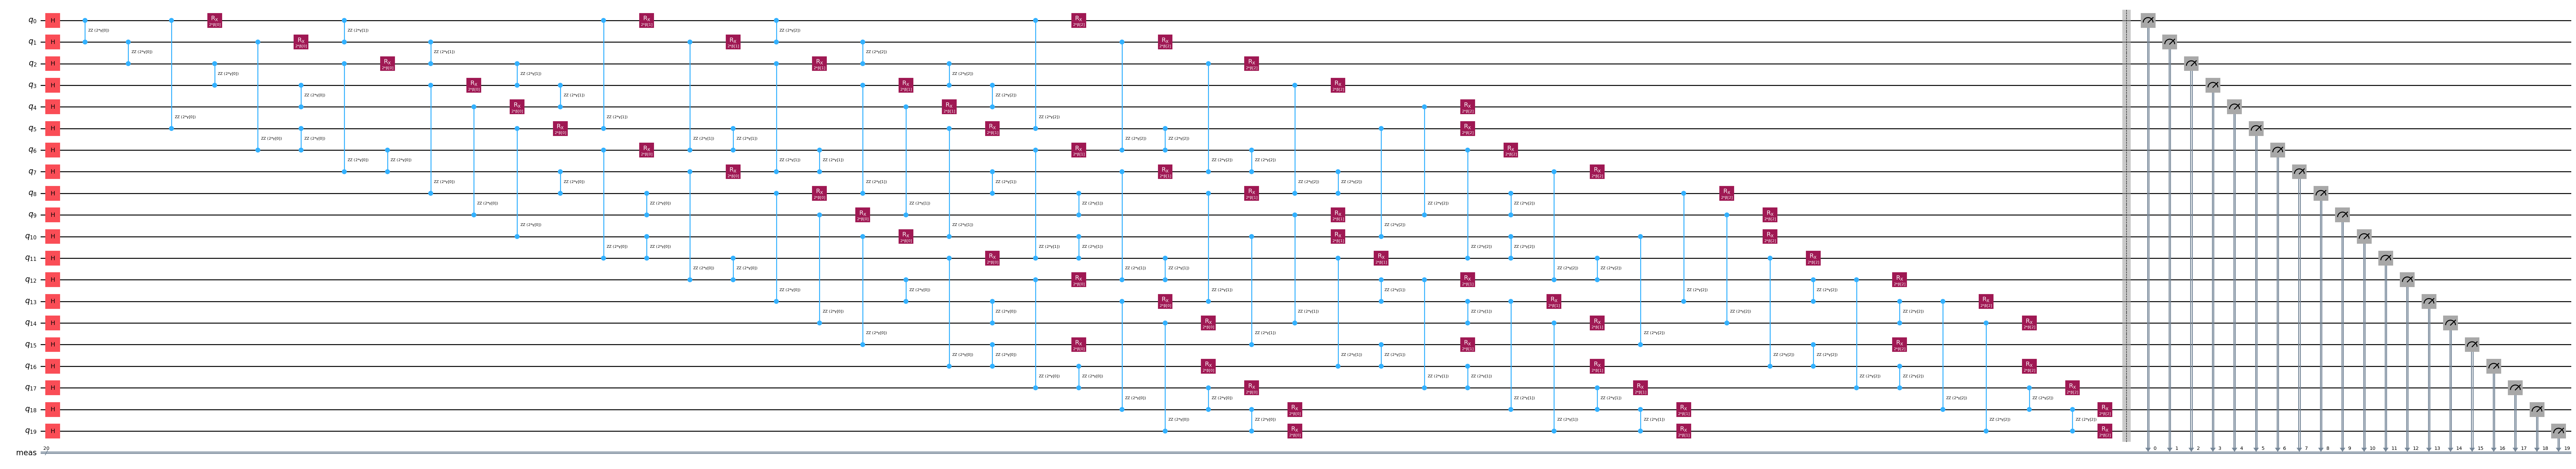

In [33]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [34]:
# Initial params
init_params = [np.pi / 2] * 6
# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model, "shots":1})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")
def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: -0.224609375
[Noiseless] Params: [2.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.02734375
[Noiseless] Params: [1.57079633 2.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: -0.025390625
[Noiseless] Params: [1.57079633 1.57079633 2.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.0078125
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 2.57079633 1.57079633 1.57079633], Cost: -0.037109375
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633 2.57079633 1.57079633], Cost: 0.138671875
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 2.57079633], Cost: 0.09375
[Noiseless] Params: [1.18462243 1.26544953 1.2145584  1.2834111  1.01398746 1.08284017], Cost: -2.6953125
[Noiseless] Params: [1.11595244 1.21115232 1.15121166 1.23230785 0.0249561  0.99607111], Cost: 1.89453125
[Noiseless] 

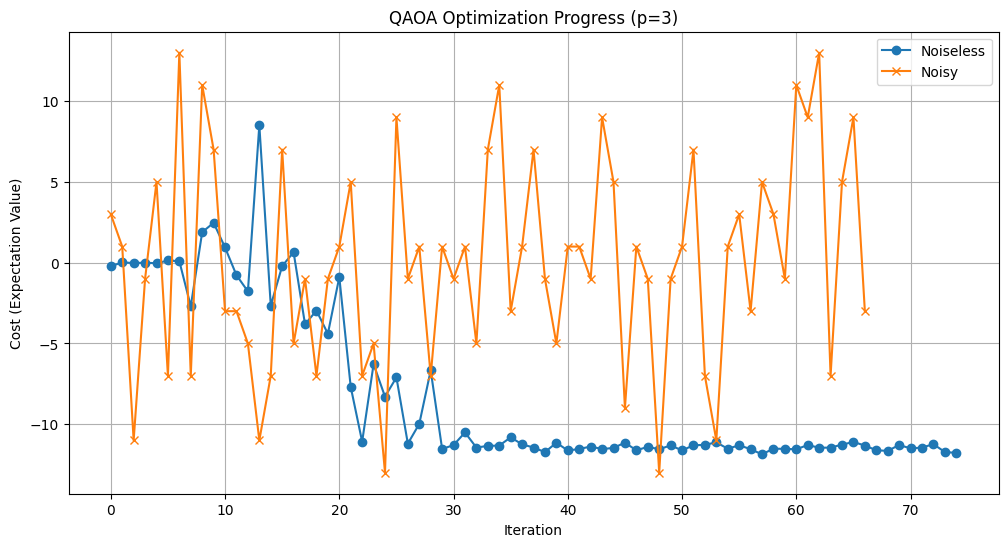

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', label="Noiseless")
plt.plot(objective_func_vals_noisy, marker='x', label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.legend()
plt.show()

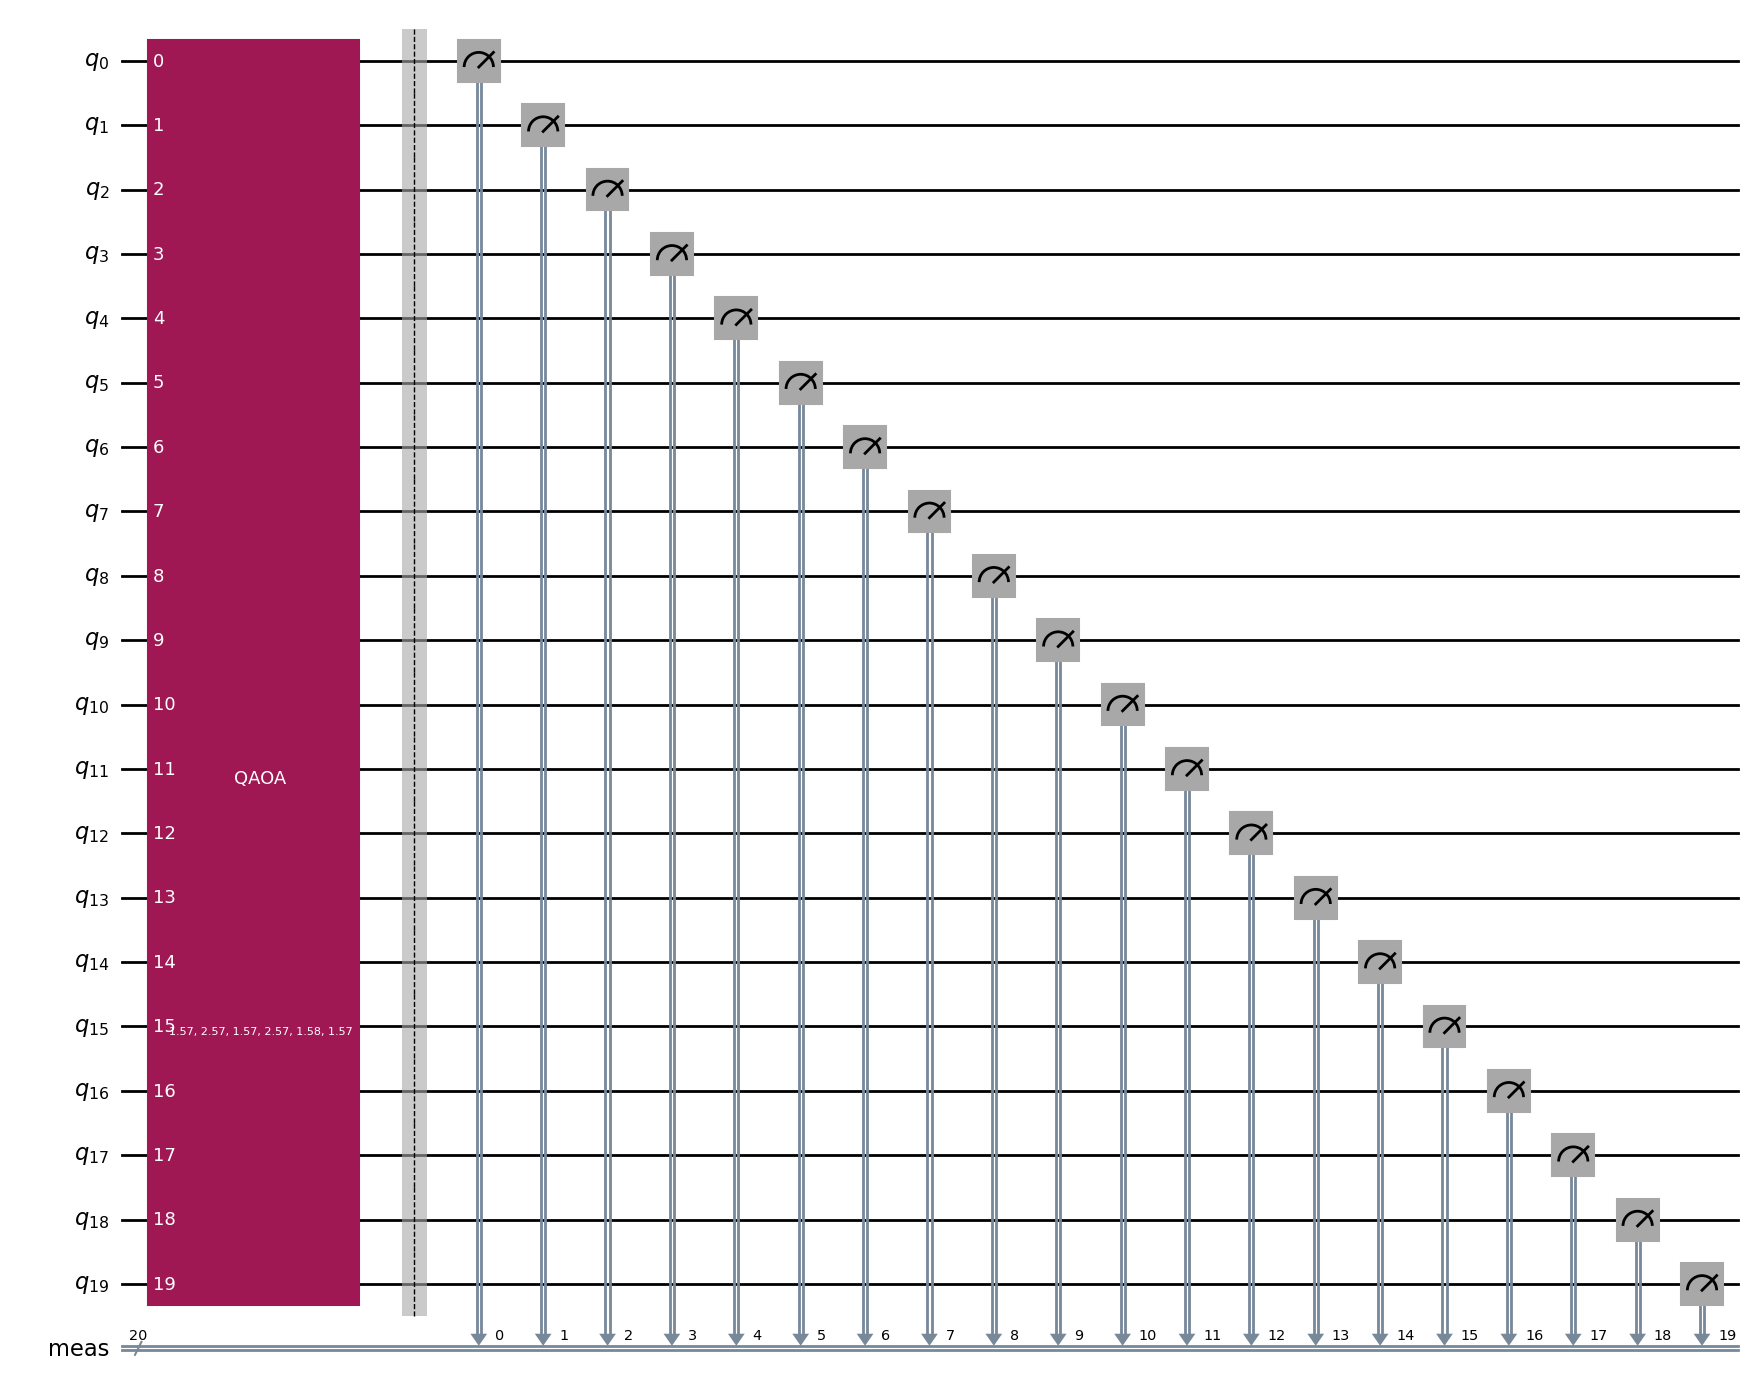

In [36]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

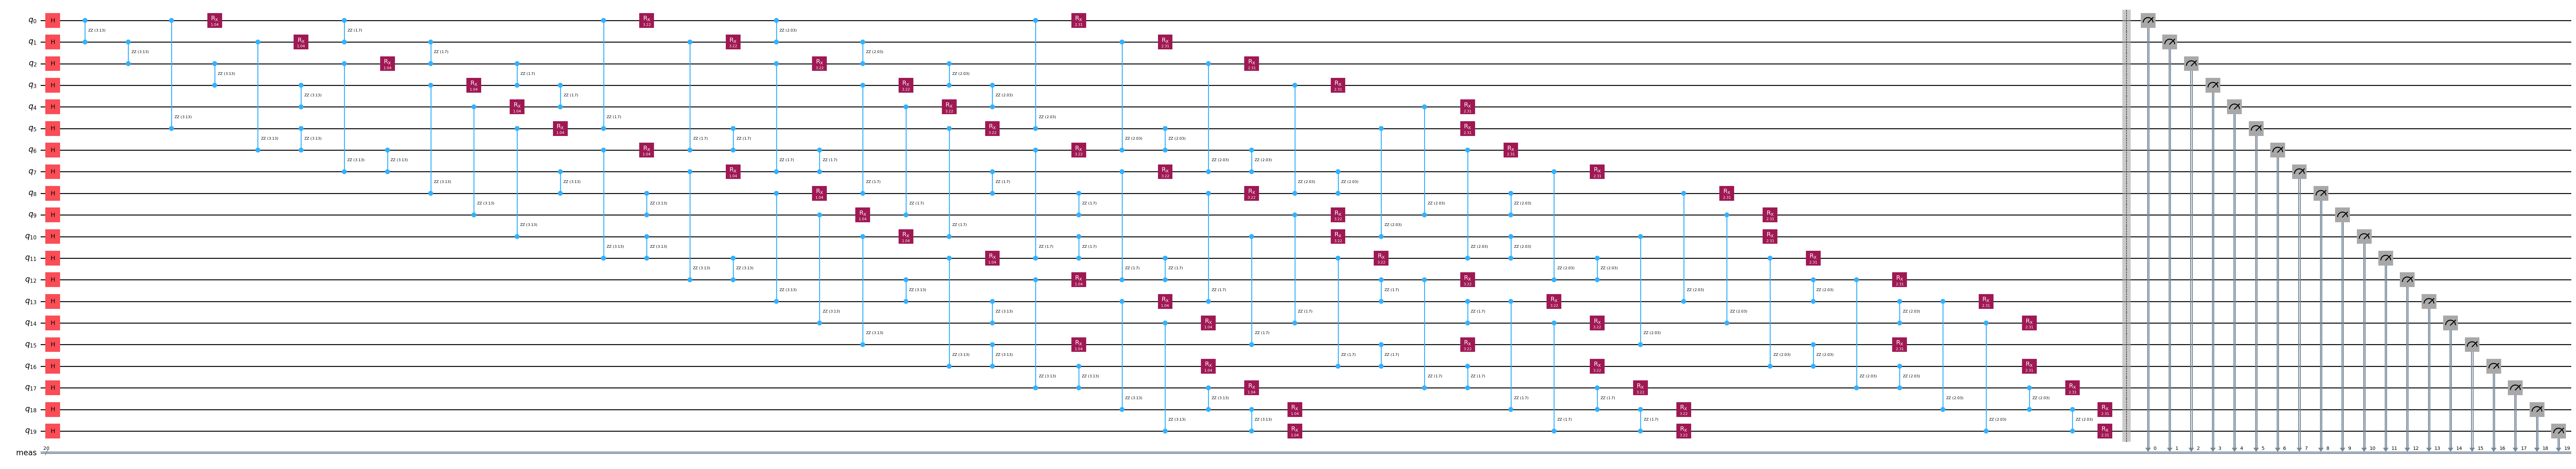

In [37]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [38]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=3)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=2)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [39]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

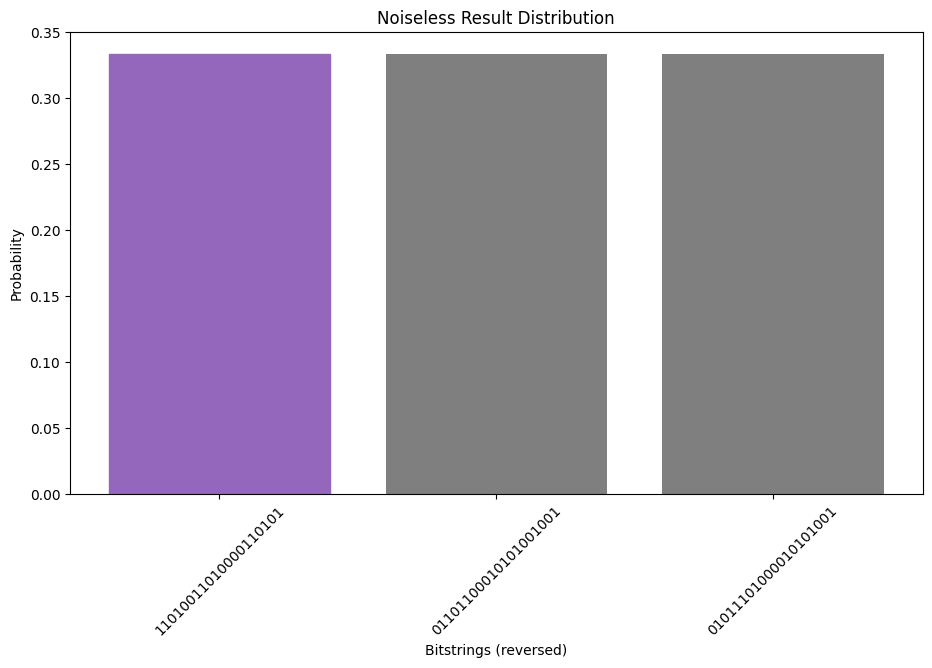

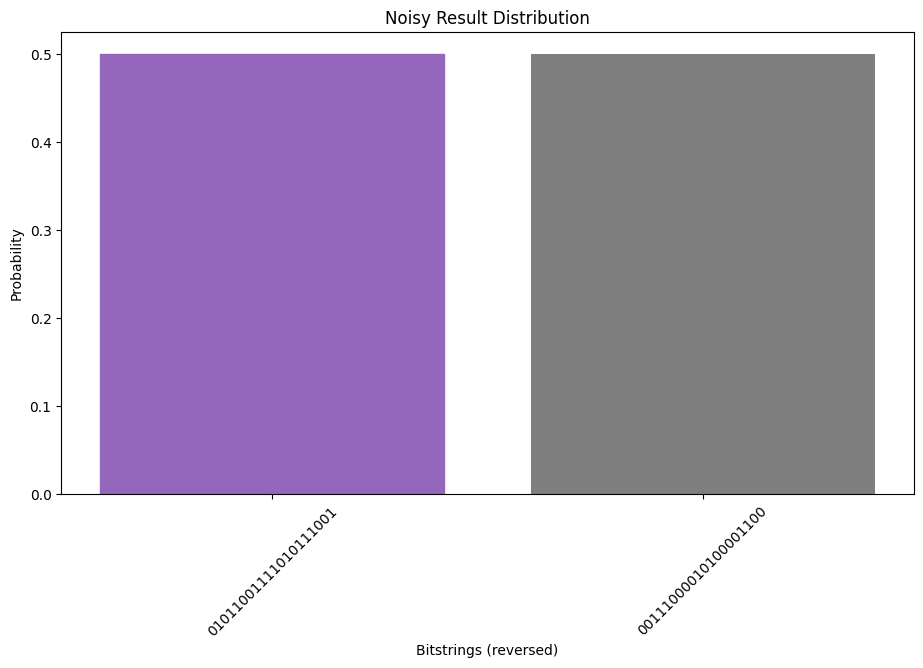

Noiseless bitstring: [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1]
Noisy bitstring: [0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


In [40]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 19
Cut value (noisy): 16


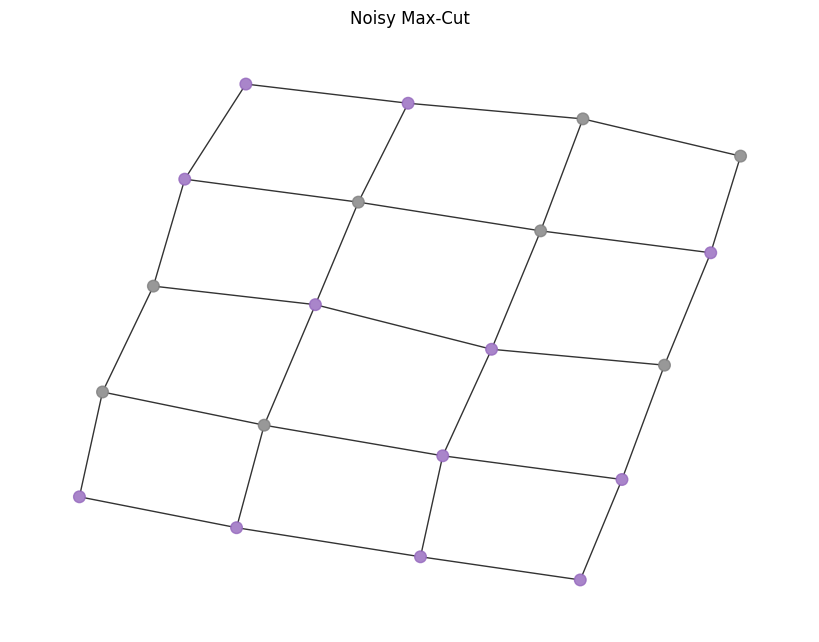

In [41]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

# Compare


As the QAOA level (p) goes up, the cost thing and the Max-Cut score get better, for all sizes of graphs. This shows that deep QAOA lines often give good looks of the Max-Cut issue.